<a href="https://colab.research.google.com/github/jhuee/DeepLearning/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3i_4xauu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3i_4xauu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version : ", torch.__version__)

Torch version :  2.3.1+cu121


In [ ]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32") #전처리 함수 로드 (vision transformer)
model.cuda() #GPU로 연산 가속화
input_resolution = model.visual.input_resolution #모델이 예상하는 입력 이미지 해상도
context_length = model.context_length #텍스트 최대길이
vocab_size = model.vocab_size #보카 사이즈

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Image Preprocessing
resize the input images and cener-crop them to conform with the image resolution that the model expects.
Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7d66ce22eb90>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text Preprocessing

we use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs ar padded to becom 77 tokens long, which is what the CLIP models expects.


In [ ]:
clip.tokenize("Hello wolrd")

tensor([[49406,  3306,  2798,  1973, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

#IPython 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

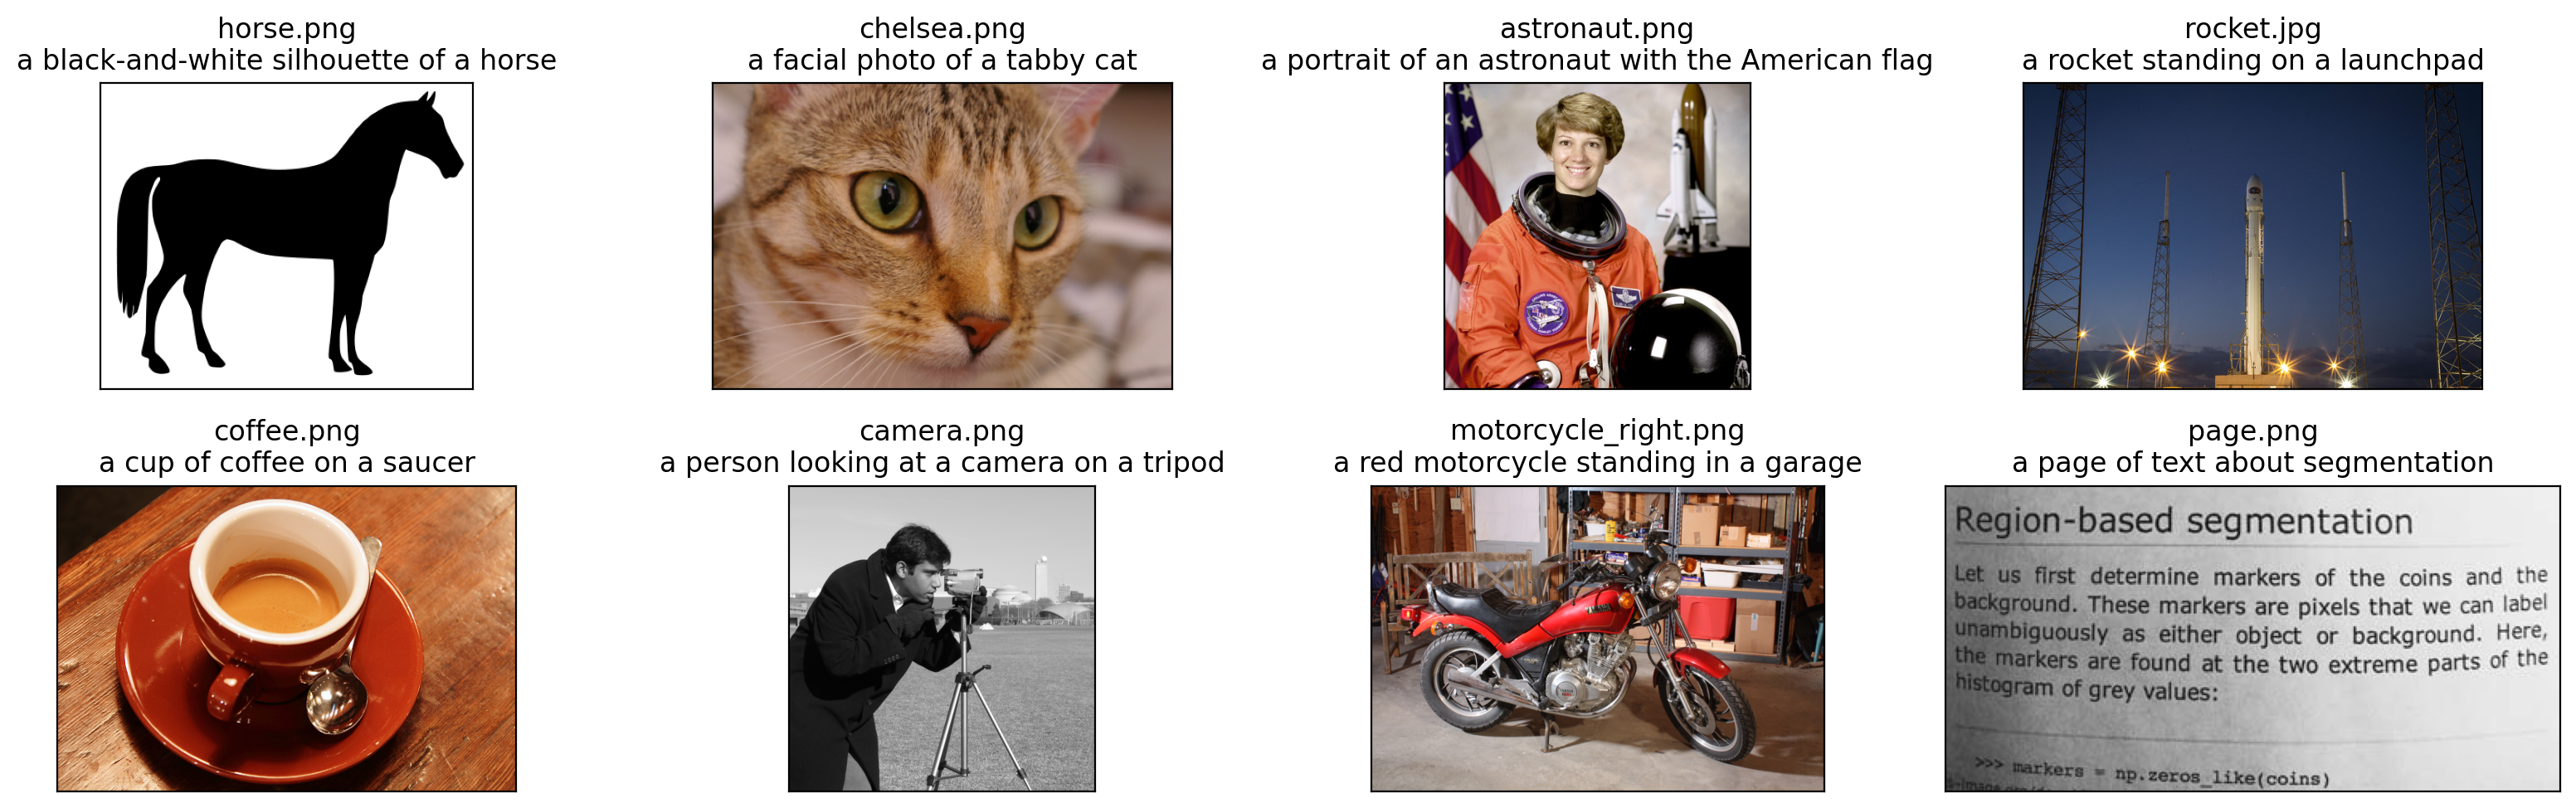

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16,5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
      continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

## Building features
We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is"+desc for desc in texts]).cuda()

In [ ]:
with torch.no_grad(): # gradient 계산 X
    image_features = model.encode_image(image_input).float() #image feature 추출
    text_features = model.encode_text(text_tokens).float() # text feature 추출

## Calculating cosine similarity
We normalize the features and calculate the dot product of each pair.


In [ ]:
image_features /= image_features.norm(dim=-1, keepdim = True)
text_features /= text_features.norm(dim= -1, keepdim = True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

NameError: name 'image_features' is not defined